# Called Third Strike
## Part 4. First crude non-neural network model

![](./resources/baseball_umpire_home_plate_1.jpg)

This project's goal is to build probability models for as to whether a pitch will be called a strike or not. The intended models are to be:
1. A neural network (NN) based approach.
2. A non-NN based approach.

---

__**This Notebook's**__ objective is to quickly build a simple working ML classication model to give a baseline to compare against as we iterate versions. 

---
---

### Table of Contents<a id='toc'></a>

<a href='#data_prep'>1. Data Preprocessing</a>

~<a href='#build_model'>2. Build Model</a>~ Straight to Random Search!

<a href='#random_search'>3. Random Hyperparameter Search</a>

<a href='#summary'>4. Summary</a>

...

<a href='#the_end'>Go to the End</a>

---

---  

<span style="font-size:0.5em;">Tag 1</span>

### Data Preprocessing<a id='data_prep'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>


#### Libraries


---

#### Data Import 

Retrieve the latest version of our train/test files that we built during [initial exploration](02_data_exploration.ipynb).

In [2]:
# Data wrangling and operations
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# try:
#     import plotly_express as pex
# except ImportError:
#     !pip install plotly_express
# except ModuleNotFoundError:
#     !pip install plotly_express

# Estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator

# Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Assessment
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_curve, RocCurveDisplay

In [3]:
df_train = pd.read_pickle('../data/train_enriched.pkl')
df_test = pd.read_pickle('../data/test_enriched.pkl')

Let's refamiliarize ourselves with the features.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pitch_id              350959 non-null  object        
 1   inning                350959 non-null  int64         
 2   side                  350959 non-null  object        
 3   run_diff              350959 non-null  int64         
 4   at_bat_index          350959 non-null  int64         
 5   pitch_of_ab           350959 non-null  int64         
 6   batter                350959 non-null  int64         
 7   pitcher               350959 non-null  int64         
 8   catcher               350959 non-null  int64         
 9   umpire                350959 non-null  int64         
 10  bside                 350959 non-null  object        
 11  pside                 350959 non-null  object        
 12  stringer_zone_bottom  350959 non-null  float64       
 13 

---

#### Feature Selection and Prep

Select features:

For our initial super simple model, let's just pick four features: 
- `px` which is the horizontal location of the pitch at the plate
- `pz` which is the vertical location
- `stringer_zone_bottom` which is an estimate of current batter's strike zone bottom
- `stringer_zone_top` which is an estimate of current batter's strike zone top

In [5]:
# Features selected
feat_select = ['px', 'pz', 'stringer_zone_bottom', 'stringer_zone_top']

Prep features:

In [6]:
# Get just the selected features
df_X = df_train[feat_select]
display(df_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   px                    350959 non-null  float64
 1   pz                    350959 non-null  float64
 2   stringer_zone_bottom  350959 non-null  float64
 3   stringer_zone_top     350959 non-null  float64
dtypes: float64(4)
memory usage: 13.4 MB


None

While we are at it, let's prep our targets:

In [7]:
df_y = df_train['strike_bool']
display(pd.DataFrame(df_y).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   strike_bool  350959 non-null  int64
dtypes: int64(1)
memory usage: 5.4 MB


None

---

#### Feature Engineering

Select features:

For a neural network we will need to numerically represent our data (e.g. one-hot-encode any categorical features), as well as scale/normalize the data. 

All the selected features for this round are numerical, so we don't have to worry about encoding any categories. For scaling I'm choosing to *standardize*.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

---

#### Train / Test


Create train/test splits.

Breakout parameters for easy access.

In [9]:
# Parameters
test_size = 0.20
random_state = 24

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_y, test_size=test_size
                                                    ,stratify=df_y, random_state=random_state)

---  

<span style="font-size:0.5em;">Tag 2</span>

### Build Model / Hyperparameter Search<a id='random_search'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

---  

For expediency we are going to use a pipeline and random hyperparameter search to scour through different classifiers and hyperparameter sets to come up with a good candidate.

We'll create a `DummyEstimator` class to act as a placeholder to which we can pass the different classifiers.

In [11]:
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

Create the pipeline of dictionaries of classifiers and their respective grids of potential hyperparameters.

In [12]:
# Create a pipeline
pipe = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator

# Candidate learning algorithms and their hyperparameters
# For selected hyperparameters aimed to select a reasonable range for each.
search_space = [{'clf': [LogisticRegression()], # Actual Estimator
                 'clf__penalty': ['l1', 'l2', 'elasticnet'],
                 'clf__C': np.logspace(-4, 4, 20)
                },
                {'clf': [DecisionTreeClassifier()],  # Actual Estimator
                 'clf__criterion': ['gini', 'entropy'],
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': [0.25, 0.5, 0.75, 1]
                },
                {'clf': [RandomForestClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                 'clf__max_samples': [0.25, 0.5, 0.75, 1]
                },
                {'clf': [GradientBoostingClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                },
                {'clf': [XGBClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                 'clf__max_samples': [0.25, 0.5, 0.75, 1]
                }
               ]

# GradientBoostingClassifier(
# RandomForestClassifier(
    
# Create grid search 
# gs = GridSearchCV(pipe, search_space, random_state=random_state)
rs = RandomizedSearchCV(pipe, search_space, random_state=random_state
                        ,n_iter=10 # To limit search time 
                        ,cv=3      # I like 5 as rule of thumb, but again to limit search time
                        ,verbose=True, refit=True, scoring='accuracy')

Fit the random search cv object.

In [13]:
rs_results = rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[04:17:11] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:17:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:17:59] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
 

Check the results.

In [14]:
rs_results.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=8, max_features='sqrt',
                               max_samples=0.25, min_child_weight=1,
                               min_samples_split=0.18, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verb

In [15]:
rs_results.best_params_

{'clf__n_estimators': 50,
 'clf__min_samples_split': 0.18,
 'clf__max_samples': 0.25,
 'clf__max_features': 'sqrt',
 'clf__max_depth': 8,
 'clf__criterion': 'entropy',
 'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, criterion='entropy',
               gamma=None, gpu_id=None, importance_type='gain',
               interaction_constraints=None, learning_rate=None,
               max_delta_step=None, max_depth=8, max_features='sqrt',
               max_samples=0.25, min_child_weight=None, min_samples_split=0.18,
               missing=nan, monotone_constraints=None, n_estimators=50,
               n_jobs=None, num_parallel_tree=None, random_state=None,
               reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
               subsample=None, tree_method=None, validate_parameters=None,
               verbosity=None)}

In [16]:
rs_results.best_score_

0.9277087406995835

In [17]:
rs_results.cv_results_

{'mean_fit_time': array([4.80305528e+01, 5.36194110e+00, 9.71594106e+01, 1.58016459e+00,
        1.07164497e+02, 1.45922534e+00, 3.17741235e-02, 1.66093769e+02,
        3.11272144e-02, 4.29713298e+01]),
 'std_fit_time': array([4.36898858e-02, 8.86551417e-02, 1.39643866e+00, 2.54405510e-02,
        1.83693578e+00, 3.57452299e-02, 3.41383012e-04, 2.01723019e+00,
        2.28472267e-04, 1.26937558e+00]),
 'mean_score_time': array([0.25864474, 0.41561158, 0.32751012, 0.32569416, 0.32725056,
        0.32176932, 0.        , 0.49116357, 0.        , 0.26245904]),
 'std_score_time': array([0.09504436, 0.00358929, 0.05125323, 0.01024461, 0.04719376,
        0.00112042, 0.        , 0.08934127, 0.        , 0.05295346]),
 'param_clf__n_estimators': masked_array(data=[50, 100, 200, 100, 100, 100, 100, 200, 50, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__min_samples

In [18]:
df_rs_res = pd.DataFrame(rs_results.cv_results_)

In [19]:
df_rs_res.shape

(10, 18)

In [20]:
df_rs_res.head(10).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,48.030553,5.361941,97.159411,1.580165,107.164497,1.459225,0.031774,166.093769,0.031127,42.97133
std_fit_time,0.04369,0.088655,1.396439,0.025441,1.836936,0.035745,0.000341,2.01723,0.000228,1.269376
mean_score_time,0.258645,0.415612,0.32751,0.325694,0.327251,0.321769,0.0,0.491164,0.0,0.262459
std_score_time,0.095044,0.003589,0.051253,0.010245,0.047194,0.00112,0.0,0.089341,0.0,0.052953
param_clf__n_estimators,50,100,200,100,100,100,100,200,50,50
param_clf__min_samples_split,0.18,0.34,0.14,0.26,0.42,0.34,0.22,0.22,0.3,0.38
param_clf__max_samples,0.25,0.75,0.5,0.25,0.75,1,NaN,0.75,NaN,0.5
param_clf__max_features,sqrt,sqrt,log2,log2,log2,sqrt,sqrt,sqrt,auto,auto
param_clf__max_depth,8,3,4,10,9,7,3,7,5,7
param_clf__criterion,entropy,gini,gini,gini,gini,entropy,gini,entropy,entropy,entropy


Let's pickle the random search results.

In [21]:
str_ts = datetime.now().strftime("%Y%m%d_%H%M")
file_nm = 'classic_rs_1st_pass_' + str_ts
file_path = './models/rs_results/' + file_nm + '.pickle'
# pred_path = './predictions/test/' + file_nm + '.csv'

display(file_path)

with open(file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_results, f, pickle.HIGHEST_PROTOCOL)

# Test loading pickle
load_path = './models/rs_results/classic_rs_1st_pass_20220505_1544.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_rez_unpkl = pickle.load(f)    

'./models/rs_results/classic_rs_1st_pass_20220507_0441.pickle'

In [22]:
rs_results.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=8, max_features='sqrt',
                               max_samples=0.25, min_child_weight=1,
                               min_samples_split=0.18, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verb

In [23]:
rs_rez_unpkl.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, max_features='auto',
                               max_samples=0.5, min_child_weight=1,
                               min_samples_split=0.4111111111111111,
                               missing=nan, monotone_constraints='()',
                               n_estimators=50, n_jobs=16, num_parallel_tree=1,
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_param

Good enough. Testing equality won't work using simple '=='

#### Review Results

Let's review the best model of the random selected models. Load from pickle if necessary.

In [24]:
%%script echo skipping
# Test loading pickle
load_path = './models/rs_results/classic_rs_1st_pass_20220505_1544.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_results = pickle.load(f)    

skipping


In [25]:
rs_results.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=8, max_features='sqrt',
                               max_samples=0.25, min_child_weight=1,
                               min_samples_split=0.18, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verb

Let's look at the best accuracy score, and the parameters that produced them.

In [26]:
display(rs_results.best_score_, rs_results.best_params_)

0.9277087406995835

{'clf__n_estimators': 50,
 'clf__min_samples_split': 0.18,
 'clf__max_samples': 0.25,
 'clf__max_features': 'sqrt',
 'clf__max_depth': 8,
 'clf__criterion': 'entropy',
 'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, criterion='entropy',
               gamma=None, gpu_id=None, importance_type='gain',
               interaction_constraints=None, learning_rate=None,
               max_delta_step=None, max_depth=8, max_features='sqrt',
               max_samples=0.25, min_child_weight=None, min_samples_split=0.18,
               missing=nan, monotone_constraints=None, n_estimators=50,
               n_jobs=None, num_parallel_tree=None, random_state=None,
               reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
               subsample=None, tree_method=None, validate_parameters=None,
               verbosity=None)}

Let's look at it as an estimator object.

In [27]:
rs_best = rs_results.best_estimator_
display(rs_best)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=8, max_features='sqrt',
                               max_samples=0.25, min_child_weight=1,
                               min_samples_split=0.18, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verb

Let's look at a high level plot of the model, to make sure it makes sense vis a vis the best params.

Now let's look at performance vs Test.

In [28]:
display(f"test accuracy: {rs_best.score(X_test, y_test)}")
display(f"train accuracy: {rs_results.best_score_}")

'test accuracy: 0.9280829724185092'

'train accuracy: 0.9277087406995835'

Consistent, and aligns. That Test score is a smidge higher than train is a little weird, but isn't egregiously so, so will go with it for now.

Let's get some predictions and review some high level classification metrics:

In [29]:
rs_pred = rs_best.predict(X_test)

*Confusion Matrix*

In [30]:
from sklearn.metrics import (confusion_matrix, precision_score, recall_score
                             ,plot_roc_curve
                            )

In [31]:
cm = confusion_matrix(y_test, rs_pred)
display(cm)

array([[45691,  2521],
       [ 2527, 19453]])

*Accuracy*

In [32]:
display("What % of pitches did we correctly categorize?")
display(f"test accuracy: {round(rs_best.score(X_test, y_test), 3)}")

'What % of pitches did we correctly categorize?'

'test accuracy: 0.928'

*Precision*

In [33]:
precision = precision_score(y_test, rs_pred)
display("What % predicted strikes did we get correct?")
display(f"Positive Predictive Value: {round(precision,5)}")

'What % predicted strikes did we get correct?'

'Positive Predictive Value: 0.88527'

*Recall*

In [34]:
recall = recall_score(y_test, rs_pred)
display("What percent of actual strikes did we get capture?")
display(f"True Positive Rate: {round(recall, 5)}")

'What percent of actual strikes did we get capture?'

'True Positive Rate: 0.88503'

*ROC/AUC*

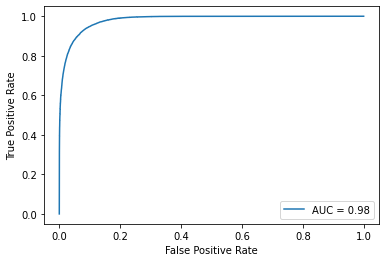

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, rs_best.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

AUC of 0.98!

---  

<span style="font-size:0.5em;">Tag 5</span>

### Summary <a id='summary'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

Show best model again:

In [36]:
rs_best.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=8, max_features='sqrt',
                               max_samples=0.25, min_child_weight=1,
                               min_samples_split=0.18, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                     

<span style="color:blue">
    
Our metric of choice is Accuracy, and the best model found by the random search over **10** iterations had a:  

- training accuracy of **0.928**
- test accuracy was **0.928** as well
    
The best model is an **XGBoost classifier**.

Other classification metrics for context are:
- Precision/Positive Predictive Value: **0.885**
- Recall/True Positive Rate: **0.885**
- ROC AUC: **0.98**

All these metrics I would consider to be very good performance, contigent on specific use case of ultimate customer(s). For example a requirement might that the customer might want to maximize PPV as much as possible and would like to target >0.90.
    
Also, note that these results are almost identical to what we arrived at on our <u>[first run of a neural network](./03_first_crude_neural_network.ipynb)</u>! 
    
</span>

---  

<span style="font-size:0.5em;">Tag 5</span>

<a id='the_end'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

-----